In [37]:
import torch
from torchvision import models
from PIL import Image
from torchvision import transforms
import os
from tqdm import tqdm
import matplotlib.pyplot as plt 
# dir(models)

# 模型加载

## 平均池化

In [8]:
res50_avg = models.resnet50(pretrained=True)
# pre_dict = res50.state_dict()
res50_avg.to('cpu')

res50_avg.fc = torch.nn.Linear(2048,2048)
torch.nn.init.zeros_(res50_avg.fc.bias)

for param in res50_avg.parameters():
    param.requires_grad = False

## 最大池化

In [7]:
res50_max = models.resnet50(pretrained=True)
# pre_dict = res50.state_dict()
res50_max.to('cpu')
# 修改为最大池化
res50_max.avgpool = torch.nn.AdaptiveMaxPool2d((1, 1))
res50_max.fc = torch.nn.Linear(2048,2048)
torch.nn.init.zeros_(res50_max.fc.bias)
for param in res50_max.parameters():
    param.requires_grad = False

# 图片输入以及处理

## step by step

In [14]:
img_path = 'data/VisDrone_MOT/train/reid/uav0000013_00000_v_000002/000001.jpg'

In [15]:
raw_img = Image.open(img_path)

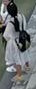

In [16]:
raw_img

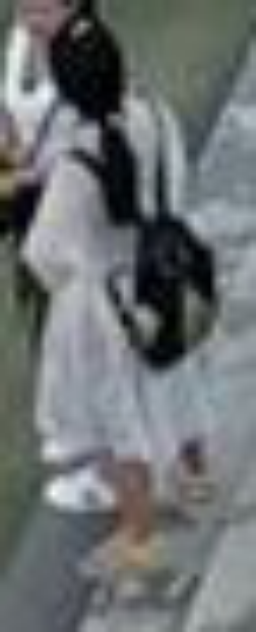

In [19]:
transforms.Resize(256)(raw_img)

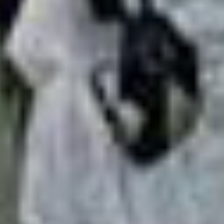

In [20]:
transforms.CenterCrop(224)(transforms.Resize(256)(raw_img))

In [22]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
input_tensor = preprocess(raw_img)

In [24]:
input_tensor.shape

torch.Size([3, 224, 224])

In [25]:
input_batch = input_tensor.unsqueeze(0)

In [26]:
input_batch.shape

torch.Size([1, 3, 224, 224])

In [27]:
input_batch = input_batch.to('cpu')

In [29]:
q_feature = res50(input_batch)

In [31]:
q_feature.shape

torch.Size([1, 2048])

## function

In [9]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
def get_feature(img_path, model):
    raw_img = Image.open(img_path)
    input_tensor = preprocess(raw_img)
    input_batch = input_tensor.unsqueeze(0)
    return model(input_batch)[0]

# 特征计算

In [16]:
prefix = 'data/VisDrone_MOT/train/reid/uav0000013_00000_v_000002'
imgs = os.listdir(prefix)
imgs.sort()

In [19]:
prefix2 = 'data/VisDrone_MOT/train/reid/uav0000013_00000_v_000003'
imgs2 = os.listdir(prefix2)
imgs2.sort()

In [91]:
prefix3 = 'data/VisDrone_MOT/train/reid/uav0000013_00000_v_000005'
imgs3 = os.listdir(prefix3)
imgs3.sort()

## 测试两张图片之间的余弦距离

### 同一目标

#### 平均池化

In [17]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[0]}', res50_avg),
                        get_feature(f'{prefix}/{imgs[1]}', res50_avg),
                        dim=0)

tensor(0.9987)

#### 最大池化

In [18]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[0]}', res50_max),
                        get_feature(f'{prefix}/{imgs[1]}', res50_max),
                        dim=0)

tensor(0.9581)

In [93]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[0]}', res50_max),
                        get_feature(f'{prefix}/{imgs[4]}', res50_max),
                        dim=0)

tensor(0.9603)

In [94]:
torch.cosine_similarity(get_feature(f'{prefix2}/{imgs2[0]}', res50_max),
                        get_feature(f'{prefix2}/{imgs2[4]}', res50_max),
                        dim=0)

tensor(0.9592)

In [92]:
torch.cosine_similarity(get_feature(f'{prefix3}/{imgs3[0]}', res50_max),
                        get_feature(f'{prefix3}/{imgs3[4]}', res50_max),
                        dim=0)

tensor(0.9566)

### 不同目标

#### 平均池化

In [22]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[0]}', res50_avg),
                        get_feature(f'{prefix2}/{imgs2[1]}', res50_avg),
                        dim=0)

tensor(0.9983)

#### 最大池化

In [21]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[0]}', res50_max),
                        get_feature(f'{prefix2}/{imgs2[1]}', res50_max),
                        dim=0)

tensor(0.9544)

In [96]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[0]}', res50_max),
                        get_feature(f'{prefix2}/{imgs2[0]}', res50_max),
                        dim=0)

tensor(0.9559)

In [97]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[4]}', res50_max),
                        get_feature(f'{prefix2}/{imgs2[4]}', res50_max),
                        dim=0)

tensor(0.9586)

In [98]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[0]}', res50_max),
                        get_feature(f'{prefix3}/{imgs3[0]}', res50_max),
                        dim=0)

tensor(0.9547)

In [99]:
torch.cosine_similarity(get_feature(f'{prefix}/{imgs[4]}', res50_max),
                        get_feature(f'{prefix3}/{imgs3[4]}', res50_max),
                        dim=0)

tensor(0.9535)

## 余弦相似度序列

In [23]:
img2feat = {}
for img in tqdm(imgs):
    img2feat[img] = get_feature(f'{prefix}/{img}', res50_max)

100%|██████████| 177/177 [00:18<00:00,  9.63it/s]


In [25]:
t = torch.Tensor()

In [27]:
t = torch.concat((t, t), dim=0)

In [30]:
dv = []
end = 100
for img in imgs[:end]:
    dv.append(torch.cosine_similarity(img2feat[img],img2feat[imgs[end]],dim=0))
t = torch.stack(dv)
t

tensor([0.9524, 0.9465, 0.9525, 0.9464, 0.9569, 0.9526, 0.9533, 0.9496, 0.9468,
        0.9443, 0.9488, 0.9555, 0.9515, 0.9556, 0.9494, 0.9566, 0.9530, 0.9512,
        0.9520, 0.9506, 0.9485, 0.9525, 0.9537, 0.9548, 0.9536, 0.9533, 0.9559,
        0.9541, 0.9498, 0.9512, 0.9529, 0.9535, 0.9448, 0.9484, 0.9492, 0.9495,
        0.9507, 0.9510, 0.9548, 0.9524, 0.9553, 0.9530, 0.9524, 0.9530, 0.9481,
        0.9450, 0.9516, 0.9563, 0.9539, 0.9515, 0.9525, 0.9556, 0.9432, 0.9524,
        0.9513, 0.9474, 0.9463, 0.9486, 0.9461, 0.9487, 0.9512, 0.9552, 0.9528,
        0.9482, 0.9498, 0.9495, 0.9502, 0.9535, 0.9525, 0.9478, 0.9537, 0.9534,
        0.9505, 0.9484, 0.9538, 0.9507, 0.9512, 0.9505, 0.9499, 0.9556, 0.9579,
        0.9550, 0.9580, 0.9501, 0.9520, 0.9569, 0.9577, 0.9557, 0.9536, 0.9565,
        0.9521, 0.9530, 0.9569, 0.9546, 0.9501, 0.9521, 0.9546, 0.9489, 0.9546,
        0.9573])

In [64]:
def get_similarity(imgs, max_back = 100, begin=1, end=3000):
    t_list = []
    for i in range(max(1,begin),min(len(imgs),end)):
        ds = []
        for j in range(max(0,i-max_back),i):
            ds.append(torch.cosine_similarity(img2feat[imgs[i]],img2feat[imgs[j]],dim=0))
        t = torch.stack(ds)
        t_list.append(t.mean())
    ts = torch.stack(t_list)
    return list(range(max(1,begin),min(len(imgs),end))), ts

In [69]:
x, ts_b100_s10 = get_similarity(imgs, 10, 100, 130)
x, ts_b100_s20 = get_similarity(imgs, 20, 100, 130)
x, ts_b100_s50 = get_similarity(imgs, 50, 100, 130)
x, ts_b100_s100 = get_similarity(imgs, 100, 100, 130)

In [78]:
ts_b100_s10.var(), ts_b100_s10.std()

(tensor(6.2903e-06), tensor(0.0025))

In [79]:
ts_b100_s20.var(), ts_b100_s20.std()

(tensor(3.6421e-06), tensor(0.0019))

In [80]:
ts_b100_s50.var(), ts_b100_s50.std()

(tensor(2.9506e-06), tensor(0.0017))

In [81]:
ts_b100_s100.var(), ts_b100_s100.std()

(tensor(2.7310e-06), tensor(0.0017))

In [72]:
for i, v in zip(x, ts_b100_s100.tolist()):
    print(i, v)

100 0.9518903493881226
101 0.9548256397247314
102 0.9584434628486633
103 0.9553591012954712
104 0.9566331505775452
105 0.9582611322402954
106 0.9546585083007812
107 0.9572764039039612
108 0.9571899175643921
109 0.9555059671401978
110 0.9540311694145203
111 0.9569786190986633
112 0.956056535243988
113 0.9568078517913818
114 0.9560186266899109
115 0.9552369713783264
116 0.9564290642738342
117 0.9564383029937744
118 0.9574185013771057
119 0.9587938189506531
120 0.9577873349189758
121 0.9593273401260376
122 0.9555118680000305
123 0.9585825204849243
124 0.9593431353569031
125 0.9573584794998169
126 0.9574112892150879
127 0.9572912454605103
128 0.9571917057037354
129 0.9582272171974182


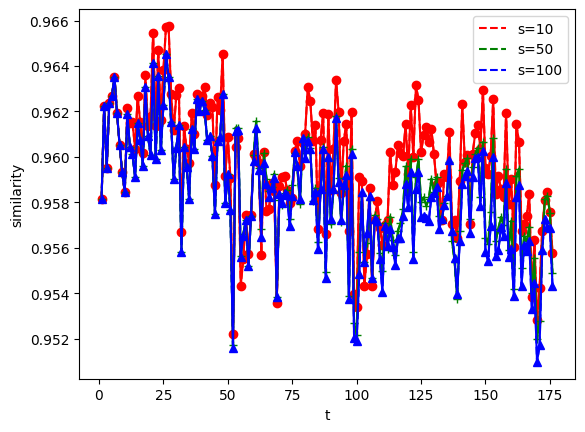

In [56]:
%matplotlib inline
# l1=plt.plot(x1,y1,'r--',label='type1')
# l2=plt.plot(x2,y2,'g--',label='type2')
# l3=plt.plot(x3,y3,'b--',label='type3')
# plt.plot(x1,y1,'ro-',x2,y2,'g+-',x3,y3,'b^-')
# plt.title('The Lasers in Three Conditions')
# plt.xlabel('row')
# plt.ylabel('column')
# plt.legend()
# plt.show()

l1=plt.plot(range(1,len(ts)+1),ts_10,'r--',label='s=10')
l2=plt.plot(range(1,len(ts)+1),ts_50,'g--',label='s=50')
l3=plt.plot(range(1,len(ts)+1),ts_100,'b--',label='s=100')
plt.plot(range(1,len(ts)+1),ts_10,'ro-',
        range(1,len(ts)+1),ts_50,'g+-',
        range(1,len(ts)+1),ts_100,'b^-')
# plt.title('')
plt.xlabel('t')
plt.ylabel('similarity')
plt.legend()
plt.show()